In [25]:
import os
import pandas as pd
from StringIO import StringIO
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#For weather scraping
import urllib2
import json
import re
%pylab inline 

from haversine import haversine

# Machine Learning Models
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# Machine Learning tools
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline


Populating the interactive namespace from numpy and matplotlib


/home/victor/anaconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['title', 'test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [26]:
current_dir = os.path.abspath('.')
train_url = current_dir + '/data/train.csv'
test_url = current_dir + '/data/test.csv'
raw_train = pd.read_csv(train_url)
raw_test = pd.read_csv(test_url)

In [27]:
train = raw_train.copy()
test = raw_test.copy()

In [28]:
raw_train.describe(include='all')

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
count,1458644,1.458644e+06,1458644,1458644,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1458644,1.458644e+06
unique,1458644,NaN,1380222,1380377,NaN,NaN,NaN,NaN,NaN,2,NaN
top,id2220643,NaN,2016-04-05 18:55:21,2016-05-16 19:40:28,NaN,NaN,NaN,NaN,NaN,N,NaN
freq,1,NaN,5,5,NaN,NaN,NaN,NaN,NaN,1450599,NaN
mean,NaN,1.534950e+00,NaN,NaN,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,NaN,9.594923e+02
std,NaN,4.987772e-01,NaN,NaN,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,NaN,5.237432e+03
min,NaN,1.000000e+00,NaN,NaN,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,NaN,1.000000e+00
25%,NaN,1.000000e+00,NaN,NaN,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,NaN,3.970000e+02
50%,NaN,2.000000e+00,NaN,NaN,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,NaN,6.620000e+02
75%,NaN,2.000000e+00,NaN,NaN,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,NaN,1.075000e+03


In [29]:
# See what columns are absent in test data
train_columns = set(train.columns)
test_columns = set(test.columns)
train_columns.difference(test_columns)

{'dropoff_datetime', 'trip_duration'}

In [30]:
# We cannot use dropoff_datetime to train our model
del train['dropoff_datetime']

# Datetime

In [31]:
train['pickup_datetime'] = pd.to_datetime(train['pickup_datetime'])
test['pickup_datetime'] = pd.to_datetime(test['pickup_datetime'])


In [40]:
train['pickup_day'] = train['pickup_datetime'].dt.day
train['pickup_date'] = train['pickup_datetime'].dt.date
train['pickup_weekday'] = train['pickup_datetime'].dt.weekday
train['pickup_hour'] = train['pickup_datetime'].dt.hour
train['pickup_month'] = train['pickup_datetime'].dt.month


test['pickup_day'] = test['pickup_datetime'].dt.day
test['pickup_date'] = test['pickup_datetime'].dt.date
test['pickup_weekday'] = test['pickup_datetime'].dt.weekday
test['pickup_hour'] = test['pickup_datetime'].dt.hour
test['pickup_month'] = test['pickup_datetime'].dt.month


In [33]:
train['pickup_isweekend'] = train['pickup_weekday'].apply(lambda x: 1 if x >= 5 else 0)
test['pickup_isweekend'] = test['pickup_weekday'].apply(lambda x: 1 if x >= 5 else 0)

In [34]:
def pickup_ampm(x):
    if x >= 6 and x <= 12:
        #morning
        return 'morning'
    elif x > 12 and x <= 18:
        #afternoon
        return 'afternoon'
    elif x > 18 and x <= 22:
        #evening
        return 'evening'
    else:
        #night
        return 'night'

In [35]:
# midnight, morning, afternoon, night
train['pickup_moment'] = train['pickup_hour'].apply(pickup_ampm)
test['pickup_moment'] = test['pickup_hour'].apply(pickup_ampm)

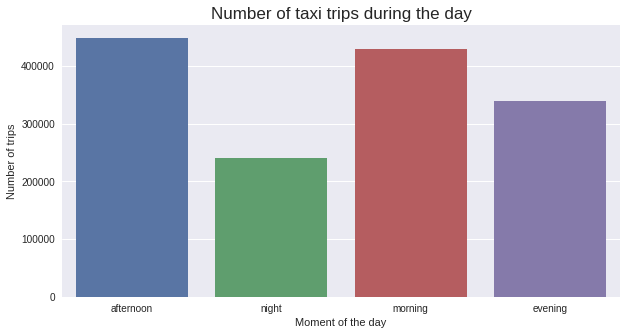

In [36]:
plt.figure(figsize=(10,5))
sns.countplot(train['pickup_moment'])
plt.xlabel('Moment of the day')
plt.ylabel('Number of trips')
plt.title('Number of taxi trips during the day', fontsize=17)

# Store and fwd flag

In [37]:
train['store_and_fwd_flag'] = train['store_and_fwd_flag'].apply(lambda x: 1 if x == 'Y' else 0)
test['store_and_fwd_flag'] = test['store_and_fwd_flag'].apply(lambda x: 1 if x == 'Y' else 0)

In [38]:
train.describe(include='all')

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_day,pickup_weekday,pickup_hour,pickup_month,pickup_isweekend,pickup_moment
count,1458644,1.458644e+06,1458644,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1458644
unique,1458644,NaN,1380222,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4
top,id2220643,NaN,2016-03-04 08:07:34,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,afternoon
freq,1,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,448972
first,NaN,NaN,2016-01-01 00:00:17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
last,NaN,NaN,2016-06-30 23:59:39,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.534950e+00,NaN,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,5.515396e-03,9.594923e+02,1.550402e+01,3.050375e+00,1.360648e+01,3.516818e+00,2.853568e-01,NaN
std,NaN,4.987772e-01,NaN,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,7.406066e-02,5.237432e+03,8.703135e+00,1.954039e+00,6.399693e+00,1.681038e+00,4.515844e-01,NaN
min,NaN,1.000000e+00,NaN,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,NaN
25%,NaN,1.000000e+00,NaN,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,0.000000e+00,3.970000e+02,8.000000e+00,1.000000e+00,9.000000e+00,2.000000e+00,0.000000e+00,NaN


In [41]:
print train.pickup_date.max()
print test.pickup_date.max()
print train.pickup_date.min()
print train.pickup_date.min()
print len(train.pickup_date.unique())
print len(test.pickup_date.unique())

2016-06-30
2016-06-30
2016-01-01
2016-01-01
182
182


In [42]:
try:
    # Import the previously scraped data
    weather_data = pd.read_csv('./data/weather_data')
    print ('Successfully imported scraped data')
except:
    # Scrape the data
    print 'Scraping the data from the web'
    raw_weather_data = pd.DataFrame()

    for month in range(1,7):
        if month == 1 or month == 3 or month == 5:
            day_range = range(1, 32)
        elif month == 4 or month == 6:
            day_range = range(1, 31)
        elif month == 2:
            day_range = range(1, 30)

        for day in day_range:  # make requests for every day of June, and append result to existing Dataframe
            print 'Collecting weather for Day {} ...'.format(day)

            ### Add in the response variable the webpage for month month and day day
            response = urllib2.urlopen('http://www.wunderground.com/history/airport/KNYC'
                                       '/2016/{}/{}/DailyHistory.html?req_city=New%20York&'
                                       'req_state=NY&req_statename=New%20York&reqdb.zip='
                                       '10001&reqdb.magic=5&reqdb.wmo=99999&format=1'.format(month, day))

            # In case this does not work
            #response = urllib2.urlopen('file:///home/data/weather_webpages/weather_{}_{}.html'.format(month, day))


            html = response.read()

            csv_file = re.sub('<br />','',html)

            weather_data_day = pd.read_csv(StringIO(csv_file))[['TemperatureC','Precipitationmm','Conditions','DateUTC']]
            raw_weather_data = raw_weather_data.append(weather_data_day)    
    raw_weather_data.to_csv(path_or_buf='./data/weather_data', index=False)
    weather_data = raw_weather_data
finally:
    print 'Weather data obtained'


Successfully imported scraped data
Weather data obtained


In [43]:
weather_data.DateUTC = pd.to_datetime(weather_data.DateUTC, format="%Y-%m-%d %H:%M")  # transform to datetime format

In [44]:
def round_hour(dt):
    if dt.minute < 30:
        return datetime.datetime(dt.year, dt.month, dt.day, dt.hour)
    else:
        return datetime.datetime(dt.year, dt.month, dt.day, dt.hour) + datetime.timedelta(hours=1)

In [45]:
weather_data.DateUTC = weather_data.DateUTC.apply(round_hour)

In [46]:
weather_data = weather_data.groupby('DateUTC', as_index=False).agg({
                                    'Precipitationmm': np.nanmean,
                                    'TemperatureC': np.nanmean,
                                    'Conditions': lambda x: x.value_counts().index[0]
                                    })

/home/victor/anaconda2/lib/python2.7/site-packages/numpy/lib/nanfunctions.py:703: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


In [47]:
print 'Missing precipitations values: {:%}'.format(sum(weather_data.Precipitationmm.isnull())/float(len(weather_data)))

Missing precipitations values: 90.032303%


In [48]:
weather_data.sample(5)

,DateUTC,Precipitationmm,Conditions,TemperatureC
1034,2016-02-13 13:00:00,NaN,Clear,-6.1
1733,2016-03-13 16:00:00,NaN,Clear,15.6
2796,2016-04-27 16:00:00,NaN,Overcast,11.7
1481,2016-03-03 04:00:00,NaN,Clear,-1.1
4172,2016-06-24 11:00:00,NaN,Clear,21.1


In [49]:
weather_data[['TemperatureC','Precipitationmm']] = (
    weather_data[['TemperatureC','Precipitationmm']].apply(lambda x: np.round(x,2)))

In [50]:
weather_data.Precipitationmm.fillna(method="pad", inplace=True)
weather_data.Precipitationmm.fillna(method="bfill", inplace=True)

In [51]:
weather_data.iloc[210:220,:]

,DateUTC,Precipitationmm,Conditions,TemperatureC
210,2016-01-10 05:00:00,0.00,Overcast,7.80
211,2016-01-10 06:00:00,0.00,Overcast,7.80
212,2016-01-10 07:00:00,0.00,Overcast,7.80
213,2016-01-10 08:00:00,0.00,Light Rain,7.80
214,2016-01-10 09:00:00,0.05,Rain,7.13
215,2016-01-10 10:00:00,0.14,Heavy Rain,7.20
216,2016-01-10 11:00:00,0.21,Rain,7.16
217,2016-01-10 12:00:00,0.20,Heavy Rain,7.40
218,2016-01-10 13:00:00,0.36,Heavy Rain,9.23
219,2016-01-10 14:00:00,0.46,Light Rain,10.00


In [52]:
weather_data.rename(columns = {'DateUTC' : 'join_time'}, inplace=True)  # This renames the weather data Date column

In [53]:
train['join_time'] = train.pickup_datetime.apply(round_hour)  # This rounds the time slots for the start time in initial dataset
train = train.merge(weather_data, how='left')

test['join_time'] = test.pickup_datetime.apply(round_hour)  # This rounds the time slots for the start time in initial dataset
test = test.merge(weather_data, how='left')

In [54]:
del train['join_time']
del test['join_time']

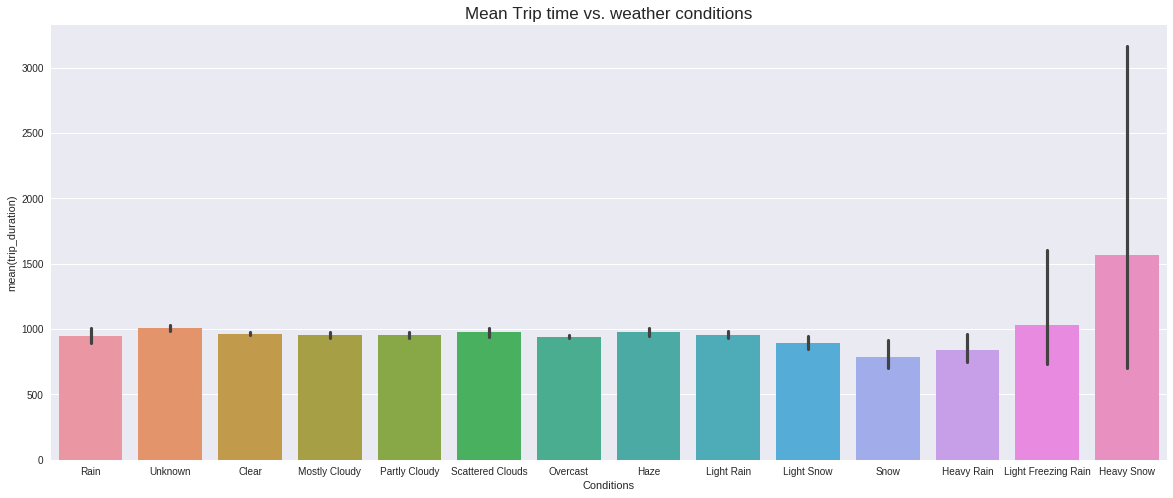

In [55]:
plt.figure(figsize=(20,8))
sns.barplot(x='Conditions', y='trip_duration', data=train, estimator=mean)
plt.title('Mean Trip time vs. weather conditions', fontsize=17)
plt.show()

In [56]:
train.columns

Index([u'id', u'vendor_id', u'pickup_datetime', u'passenger_count',
       u'pickup_longitude', u'pickup_latitude', u'dropoff_longitude',
       u'dropoff_latitude', u'store_and_fwd_flag', u'trip_duration',
       u'pickup_day', u'pickup_weekday', u'pickup_hour', u'pickup_month',
       u'pickup_isweekend', u'pickup_moment', u'pickup_date',
       u'Precipitationmm', u'Conditions', u'TemperatureC'],
      dtype='object')

In [62]:
def distance_stations(x):
    start_lat = x['pickup_latitude']
    start_long = x['pickup_longitude']
    end_lat = x['dropoff_latitude']
    end_long = x['dropoff_longitude']
    return haversine((start_lat, start_long), (end_lat, end_long))

In [63]:
train['traveled_distance'] = train.apply(distance_stations, axis=1)

In [64]:
test['traveled_distance'] = test.apply(distance_stations, axis=1)

In [65]:
train.to_csv('./data/tmp_train_data.csv')
test.to_csv('./data/tmp_test_data.csv')

In [66]:
for variable_name in ['Conditions', 'pickup_moment']:
    print 'Dummifying the {} variable ...'.format(variable_name)
    dummies = pd.get_dummies(train[variable_name])
    dummies.columns = ['{}_{}'.format(variable_name,x) for x in dummies.columns]
    train = pd.concat([train,dummies],axis=1)
    
for variable_name in ['Conditions', 'pickup_moment','pickup_datetime', 'pickup_date', 'id']:
    print 'Deleting the {} variable ...'.format(variable_name)
    del train[variable_name]

Dummifying the Conditions variable ...
Dummifying the pickup_moment variable ...
Deleting the Conditions variable ...
Deleting the pickup_moment variable ...
Deleting the pickup_datetime variable ...
Deleting the pickup_date variable ...
Deleting the id variable ...


In [67]:
for variable_name in ['Conditions', 'pickup_moment']:
    print 'Dummifying the {} variable ...'.format(variable_name)
    dummies = pd.get_dummies(test[variable_name])
    dummies.columns = ['{}_{}'.format(variable_name,x) for x in dummies.columns]
    test = pd.concat([test,dummies],axis=1)
    
for variable_name in ['Conditions', 'pickup_moment','pickup_datetime', 'pickup_date', 'id']:
    print 'Deleting the {} variable ...'.format(variable_name)
    del test[variable_name]

Dummifying the Conditions variable ...
Dummifying the pickup_moment variable ...
Deleting the Conditions variable ...
Deleting the pickup_moment variable ...
Deleting the pickup_datetime variable ...
Deleting the pickup_date variable ...
Deleting the id variable ...


In [68]:
# Split the traning and testing data
train_data = train.copy()
features = train_data.loc[:, train.columns != 'trip_duration']
target = train_data.loc[:, 'trip_duration']
X_train, X_test, y_train, y_test = train_test_split(
    features, target, test_size=0.3, random_state=42)

In [69]:
# The learning curve which is used to spot variance and bias problems
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("N (Training Set Sizes)")
    plt.ylabel("Mean Square Error")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs,
        scoring=make_scorer(mean_squared_error), train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training error")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation error")

    plt.legend(loc="best")
    plt.grid()
    return plt

In [70]:
linear_regression = linear_model.LinearRegression()
linear_regression.fit(X_train, y_train)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [71]:
X_train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_day,pickup_weekday,pickup_hour,...,Conditions_Overcast,Conditions_Partly Cloudy,Conditions_Rain,Conditions_Scattered Clouds,Conditions_Snow,Conditions_Unknown,pickup_moment_afternoon,pickup_moment_evening,pickup_moment_morning,pickup_moment_night
count,1.021050e+06,1.021050e+06,1.021050e+06,1.021050e+06,1.021050e+06,1.021050e+06,1.021050e+06,1.021050e+06,1.021050e+06,1.021050e+06,...,1.021050e+06,1.021050e+06,1.021050e+06,1.021050e+06,1.021050e+06,1.021050e+06,1.021050e+06,1.021050e+06,1.021050e+06,1.021050e+06
mean,1.535298e+00,1.663364e+00,-7.397347e+01,4.075093e+01,-7.397339e+01,4.075180e+01,5.530581e-03,1.551399e+01,3.050223e+00,1.360399e+01,...,2.317565e-01,5.373880e-02,7.013369e-03,2.960972e-02,1.464179e-03,4.524166e-02,3.076549e-01,2.327055e-01,2.943666e-01,1.652730e-01
std,4.987527e-01,1.312695e+00,6.453953e-02,3.347413e-02,6.416123e-02,3.581601e-02,7.416198e-02,8.704119e+00,1.954022e+00,6.402083e+00,...,4.219545e-01,2.255016e-01,8.345171e-02,1.695081e-01,3.823659e-02,2.078338e-01,4.615231e-01,4.225563e-01,4.557577e-01,3.714269e-01
min,1.000000e+00,0.000000e+00,-1.219332e+02,3.435970e+01,-1.219332e+02,3.218114e+01,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073734e+01,-7.399132e+01,4.073587e+01,0.000000e+00,8.000000e+00,1.000000e+00,9.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.000000e+00,1.000000e+00,-7.398175e+01,4.075410e+01,-7.397975e+01,4.075453e+01,0.000000e+00,1.500000e+01,3.000000e+00,1.400000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,2.000000e+00,2.000000e+00,-7.396734e+01,4.076834e+01,-7.396303e+01,4.076981e+01,0.000000e+00,2.300000e+01,5.000000e+00,1.900000e+01,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,1.000000e+00,3.100000e+01,6.000000e+00,2.300000e+01,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/victor/anaconda2/lib/python2.7/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    169     pkg_name = mod_name.rpartition('.')[0]
    170     main_globals = sys.modules["__main__"].__dict__
    171     if alter_argv:
    172         sys.argv[0] = fname
    173     return _run_code(code, main_globals, None,
--> 174                      "__main__", fname, loader, pkg_name)
        fname = '/home/victor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py'
        loader = <pkgutil.ImpLoader instance>
        pkg_name = 'ipykernel'
    175 
    176 def run_module(mod_name, init_globals=None,
    177                run_name=None, alter_sys=False):
    178     """Execute a module's code without importing it

...........................................................................
/home/victor/anaconda2/lib/python2.7/runpy.py in _run_code(code=<code object <module> at 0x7f84bcfd4930, file "/...2.7/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/home/victor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from '/home/victor...python2.7/site-packages/ipykernel/kernelapp.pyc'>}, init_globals=None, mod_name='__main__', mod_fname='/home/victor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py', mod_loader=<pkgutil.ImpLoader instance>, pkg_name='ipykernel')
     67         run_globals.update(init_globals)
     68     run_globals.update(__name__ = mod_name,
     69                        __file__ = mod_fname,
     70                        __loader__ = mod_loader,
     71                        __package__ = pkg_name)
---> 72     exec code in run_globals
        code = <code object <module> at 0x7f84bcfd4930, file "/...2.7/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module '__builtin__' (built-in)>, '__doc__': None, '__file__': '/home/victor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py', '__loader__': <pkgutil.ImpLoader instance>, '__name__': '__main__', '__package__': 'ipykernel', 'app': <module 'ipykernel.kernelapp' from '/home/victor...python2.7/site-packages/ipykernel/kernelapp.pyc'>}
     73     return run_globals
     74 
     75 def _run_module_code(code, init_globals=None,
     76                     mod_name=None, mod_fname=None,

...........................................................................
/home/victor/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/home/victor/anaconda2/lib/python2.7/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/home/victor/anaconda2/lib/python2.7/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    469             return self.subapp.start()
    470         if self.poller is not None:
    471             self.poller.start()
    472         self.kernel.start()
    473         try:
--> 474             ioloop.IOLoop.instance().start()
    475         except KeyboardInterrupt:
    476             pass
    477 
    478 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/victor/anaconda2/lib/python2.7/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/victor/anaconda2/lib/python2.7/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    882                 self._events.update(event_pairs)
    883                 while self._events:
    884                     fd, events = self._events.popitem()
    885                     try:
    886                         fd_obj, handler_func = self._handlers[fd]
--> 887                         handler_func(fd_obj, events)
        handler_func = <function null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    888                     except (OSError, IOError) as e:
    889                         if errno_from_exception(e) == errno.EPIPE:
    890                             # Happens when the client closes the connection
    891                             pass

...........................................................................
/home/victor/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/victor/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/victor/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/victor/anaconda2/lib/python2.7/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/victor/anaconda2/lib/python2.7/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/victor/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/victor/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'# Initiate the linear regression model and plo...ssion, title, X_train, y_train, cv=5, n_jobs=-1)', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2017-08-06T14:22:21.581664', u'msg_id': u'9864A19710534A778D568CA476D23590', u'msg_type': u'execute_request', u'session': u'586F6F5767A84157A2DB2329A8B47ABC', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'9864A19710534A778D568CA476D23590', 'msg_type': u'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method IPythonKernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = ['586F6F5767A84157A2DB2329A8B47ABC']
        msg = {'buffers': [], 'content': {u'allow_stdin': True, u'code': u'# Initiate the linear regression model and plo...ssion, title, X_train, y_train, cv=5, n_jobs=-1)', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2017-08-06T14:22:21.581664', u'msg_id': u'9864A19710534A778D568CA476D23590', u'msg_type': u'execute_request', u'session': u'586F6F5767A84157A2DB2329A8B47ABC', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'9864A19710534A778D568CA476D23590', 'msg_type': u'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/home/victor/anaconda2/lib/python2.7/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=['586F6F5767A84157A2DB2329A8B47ABC'], parent={'buffers': [], 'content': {u'allow_stdin': True, u'code': u'# Initiate the linear regression model and plo...ssion, title, X_train, y_train, cv=5, n_jobs=-1)', u'silent': False, u'stop_on_error': True, u'store_history': True, u'user_expressions': {}}, 'header': {'date': '2017-08-06T14:22:21.581664', u'msg_id': u'9864A19710534A778D568CA476D23590', u'msg_type': u'execute_request', u'session': u'586F6F5767A84157A2DB2329A8B47ABC', u'username': u'username', u'version': u'5.0'}, 'metadata': {}, 'msg_id': u'9864A19710534A778D568CA476D23590', 'msg_type': u'execute_request', 'parent_header': {}})
    385         if not silent:
    386             self.execution_count += 1
    387             self._publish_execute_input(code, parent, self.execution_count)
    388 
    389         reply_content = self.do_execute(code, silent, store_history,
--> 390                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    391 
    392         # Flush output before sending the reply.
    393         sys.stdout.flush()
    394         sys.stderr.flush()

...........................................................................
/home/victor/anaconda2/lib/python2.7/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code=u'# Initiate the linear regression model and plo...ssion, title, X_train, y_train, cv=5, n_jobs=-1)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = u'# Initiate the linear regression model and plo...ssion, title, X_train, y_train, cv=5, n_jobs=-1)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/home/victor/anaconda2/lib/python2.7/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=(u'# Initiate the linear regression model and plo...ssion, title, X_train, y_train, cv=5, n_jobs=-1)',), **kwargs={'silent': False, 'store_history': True})
    496             )
    497         self.payload_manager.write_payload(payload)
    498 
    499     def run_cell(self, *args, **kwargs):
    500         self._last_traceback = None
--> 501         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = (u'# Initiate the linear regression model and plo...ssion, title, X_train, y_train, cv=5, n_jobs=-1)',)
        kwargs = {'silent': False, 'store_history': True}
    502 
    503     def _showtraceback(self, etype, evalue, stb):
    504         # try to preserve ordering of tracebacks and print statements
    505         sys.stdout.flush()

...........................................................................
/home/victor/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell=u'# Initiate the linear regression model and plo...ssion, title, X_train, y_train, cv=5, n_jobs=-1)', store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler instance>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/home/victor/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>, <_ast.Assign object>, <_ast.Expr object>], cell_name='<ipython-input-23-2f7df9a43653>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler instance>, result=<ExecutionResult object at 7f847ab1a450, executi..._before_exec=None error_in_exec=None result=None>)
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])
   2826                 code = compiler(mod, cell_name, "single")
-> 2827                 if self.run_code(code, result):
        self.run_code = <bound method ZMQInteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f846640d330, file "<ipython-input-23-2f7df9a43653>", line 4>
        result = <ExecutionResult object at 7f847ab1a450, executi..._before_exec=None error_in_exec=None result=None>
   2828                     return True
   2829 
   2830             # Flush softspace
   2831             if softspace(sys.stdout, 0):

...........................................................................
/home/victor/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f846640d330, file "<ipython-input-23-2f7df9a43653>", line 4>, result=<ExecutionResult object at 7f847ab1a450, executi..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f846640d330, file "<ipython-input-23-2f7df9a43653>", line 4>
        self.user_global_ns = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, 'Circle': <class 'matplotlib.patches.Circle'>, ...}
        self.user_ns = {'ALLOW_THREADS': 1, 'Annotation': <class 'matplotlib.text.Annotation'>, 'Arrow': <class 'matplotlib.patches.Arrow'>, 'Artist': <class 'matplotlib.artist.Artist'>, 'AutoLocator': <class 'matplotlib.ticker.AutoLocator'>, 'Axes': <class 'matplotlib.axes._axes.Axes'>, 'BUFSIZE': 8192, 'Button': <class 'matplotlib.widgets.Button'>, 'CLIP': 0, 'Circle': <class 'matplotlib.patches.Circle'>, ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/home/victor/workspace/new_york_city_taxi/<ipython-input-23-2f7df9a43653> in <module>()
      1 
      2 
      3 # Initiate the linear regression model and plot the learning curve with default data
----> 4 linear_regression = linear_model.LinearRegression()
      5 title = "Learning curve: (Linear Regression )"
      6 plot_learning_curve(linear_regression, title, X_train, y_train, cv=5, n_jobs=-1)
      7 
      8 
      9 
     10 

...........................................................................
/home/victor/workspace/new_york_city_taxi/<ipython-input-22-3939674a0cd1> in plot_learning_curve(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), title='Learning curve: (Linear Regression )', X=         vendor_id      pickup_datetime  passeng...                 0  

[1021050 rows x 33 columns], y=1011257     844
178550     1001
551460     1048
...121958     1570
Name: trip_duration, dtype: int64, ylim=None, cv=5, n_jobs=-1, train_sizes=array([ 0.1  ,  0.325,  0.55 ,  0.775,  1.   ]))
      7         plt.ylim(*ylim)
      8     plt.xlabel("N (Training Set Sizes)")
      9     plt.ylabel("Mean Square Error")
     10     train_sizes, train_scores, test_scores = learning_curve(
     11         estimator, X, y, cv=cv, n_jobs=n_jobs,
---> 12         scoring=make_scorer(mean_squared_error), train_sizes=train_sizes)
     13     train_scores_mean = np.mean(train_scores, axis=1)
     14     train_scores_std = np.std(train_scores, axis=1)
     15     test_scores_mean = np.mean(test_scores, axis=1)
     16     test_scores_std = np.std(test_scores, axis=1)

...........................................................................
/home/victor/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_validation.py in learning_curve(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), X=         vendor_id      pickup_datetime  passeng...                 0  

[1021050 rows x 33 columns], y=1011257     844
178550     1001
551460     1048
...121958     1570
Name: trip_duration, dtype: int64, groups=None, train_sizes=array([ 0.1  ,  0.325,  0.55 ,  0.775,  1.   ]), cv=KFold(n_splits=5, random_state=None, shuffle=False), scoring=make_scorer(mean_squared_error), exploit_incremental_learning=False, n_jobs=-1, pre_dispatch='all', verbose=0)
    767             scorer, verbose) for train, test in cv_iter)
    768     else:
    769         out = parallel(delayed(_fit_and_score)(
    770             clone(estimator), X, y, scorer, train[:n_train_samples], test,
    771             verbose, parameters=None, fit_params=None, return_train_score=True)
--> 772             for train, test in cv_iter
        cv_iter = [(array([ 204210,  204211,  204212, ..., 1021047, 1021048, 1021049]), array([     0,      1,      2, ..., 204207, 204208, 204209])), (array([      0,       1,       2, ..., 1021047, 1021048, 1021049]), array([204210, 204211, 204212, ..., 408417, 408418, 408419])), (array([      0,       1,       2, ..., 1021047, 1021048, 1021049]), array([408420, 408421, 408422, ..., 612627, 612628, 612629])), (array([      0,       1,       2, ..., 1021047, 1021048, 1021049]), array([612630, 612631, 612632, ..., 816837, 816838, 816839])), (array([     0,      1,      2, ..., 816837, 816838, 816839]), array([ 816840,  816841,  816842, ..., 1021047, 1021048, 1021049]))]
    773             for n_train_samples in train_sizes_abs)
    774         out = np.array(out)
    775         n_cv_folds = out.shape[0] // n_unique_ticks
    776         out = out.reshape(n_cv_folds, n_unique_ticks, 2)

...........................................................................
/home/victor/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=-1), iterable=<generator object <genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=-1)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Sun Aug  6 14:22:24 2017
PID: 3265                  Python 2.7.13: /home/victor/anaconda2/bin/python
...........................................................................
/home/victor/anaconda2/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _fit_and_score>
        args = (LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),          vendor_id      pickup_datetime  passeng...                 0  

[1021050 rows x 33 columns], 1011257     844
178550     1001
551460     1048
...121958     1570
Name: trip_duration, dtype: int64, make_scorer(mean_squared_error), array([204210, 204211, 204212, ..., 285891, 285892, 285893]), memmap([     0,      1,      2, ..., 204207, 204208, 204209]), 0)
        kwargs = {'fit_params': None, 'parameters': None, 'return_train_score': True}
        self.items = [(<function _fit_and_score>, (LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False),          vendor_id      pickup_datetime  passeng...                 0  

[1021050 rows x 33 columns], 1011257     844
178550     1001
551460     1048
...121958     1570
Name: trip_duration, dtype: int64, make_scorer(mean_squared_error), array([204210, 204211, 204212, ..., 285891, 285892, 285893]), memmap([     0,      1,      2, ..., 204207, 204208, 204209]), 0), {'fit_params': None, 'parameters': None, 'return_train_score': True})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/victor/anaconda2/lib/python2.7/site-packages/sklearn/model_selection/_validation.py in _fit_and_score(estimator=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), X=         vendor_id      pickup_datetime  passeng...                 0  

[1021050 rows x 33 columns], y=1011257     844
178550     1001
551460     1048
...121958     1570
Name: trip_duration, dtype: int64, scorer=make_scorer(mean_squared_error), train=array([204210, 204211, 204212, ..., 285891, 285892, 285893]), test=memmap([     0,      1,      2, ..., 204207, 204208, 204209]), verbose=0, parameters=None, fit_params={}, return_train_score=True, return_parameters=False, return_n_test_samples=False, return_times=False, error_score='raise')
    233 
    234     try:
    235         if y_train is None:
    236             estimator.fit(X_train, **fit_params)
    237         else:
--> 238             estimator.fit(X_train, y_train, **fit_params)
        estimator.fit = <bound method LinearRegression.fit of LinearRegr..., fit_intercept=True, n_jobs=1, normalize=False)>
        X_train =          vendor_id      pickup_datetime  passeng...                   0  

[81684 rows x 33 columns]
        y_train = 1183345     846
1354941     975
340936     1141
...1042817     257
Name: trip_duration, dtype: int64
        fit_params = {}
    239 
    240     except Exception as e:
    241         # Note fit time as time until error
    242         fit_time = time.time() - start_time

...........................................................................
/home/victor/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/base.py in fit(self=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False), X=         vendor_id      pickup_datetime  passeng...                   0  

[81684 rows x 33 columns], y=1183345     846
1354941     975
340936     1141
...1042817     257
Name: trip_duration, dtype: int64, sample_weight=None)
    507         self : returns an instance of self.
    508         """
    509 
    510         n_jobs_ = self.n_jobs
    511         X, y = check_X_y(X, y, accept_sparse=['csr', 'csc', 'coo'],
--> 512                          y_numeric=True, multi_output=True)
    513 
    514         if sample_weight is not None and np.atleast_1d(sample_weight).ndim > 1:
    515             raise ValueError("Sample weights must be 1D array or scalar")
    516 

...........................................................................
/home/victor/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py in check_X_y(X=         vendor_id      pickup_datetime  passeng...                   0  

[81684 rows x 33 columns], y=1183345     846
1354941     975
340936     1141
...1042817     257
Name: trip_duration, dtype: int64, accept_sparse=['csr', 'csc', 'coo'], dtype='numeric', order=None, copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, multi_output=True, ensure_min_samples=1, ensure_min_features=1, y_numeric=True, warn_on_dtype=False, estimator=None)
    516     y_converted : object
    517         The converted and validated y.
    518     """
    519     X = check_array(X, accept_sparse, dtype, order, copy, force_all_finite,
    520                     ensure_2d, allow_nd, ensure_min_samples,
--> 521                     ensure_min_features, warn_on_dtype, estimator)
        ensure_min_features = 1
        warn_on_dtype = False
        estimator = None
    522     if multi_output:
    523         y = check_array(y, 'csr', force_all_finite=True, ensure_2d=False,
    524                         dtype=None)
    525     else:

...........................................................................
/home/victor/anaconda2/lib/python2.7/site-packages/sklearn/utils/validation.py in check_array(array=array([[1, '2016-01-02 16:26:39', 2, ..., 0, 0, ...02-12 10:40:05', 1, ..., 0, 1, 0]], dtype=object), accept_sparse=['csr', 'csc', 'coo'], dtype=None, order=None, copy=False, force_all_finite=True, ensure_2d=True, allow_nd=False, ensure_min_samples=1, ensure_min_features=1, warn_on_dtype=False, estimator=None)
    397             # To ensure that array flags are maintained
    398             array = np.array(array, dtype=dtype, order=order, copy=copy)
    399 
    400         # make sure we actually converted to numeric:
    401         if dtype_numeric and array.dtype.kind == "O":
--> 402             array = array.astype(np.float64)
        array = array([[1, '2016-01-02 16:26:39', 2, ..., 0, 0, ...02-12 10:40:05', 1, ..., 0, 1, 0]], dtype=object)
        array.astype = <built-in method astype of numpy.ndarray object>
    403         if not allow_nd and array.ndim >= 3:
    404             raise ValueError("Found array with dim %d. %s expected <= 2."
    405                              % (array.ndim, estimator_name))
    406         if force_all_finite:

ValueError: invalid literal for float(): 2016-02-12
___________________________________________________________________________

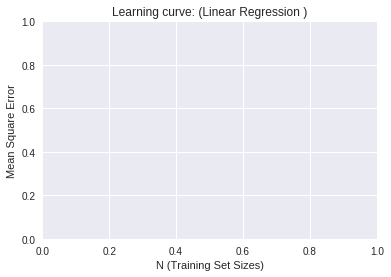

In [23]:
# Initiate the linear regression model and plot the learning curve with default data
linear_regression = linear_model.LinearRegression()
title = "Learning curve: (Linear Regression )"
plot_learning_curve(linear_regression, title, X_train, y_train, cv=5, n_jobs=-1)

In [81]:
train.dtypes

vendor_id                                  int64
pickup_datetime                   datetime64[ns]
passenger_count                            int64
pickup_longitude                         float64
pickup_latitude                          float64
dropoff_longitude                        float64
dropoff_latitude                         float64
store_and_fwd_flag                         int64
trip_duration                              int64
pickup_date                               object
pickup_weekday                             int64
pickup_hour                                int64
pickup_isweekend                           int64
Precipitationmm                          float64
TemperatureC                             float64
is_heavy_snow                              int64
Conditions_Clear                           uint8
Conditions_Haze                            uint8
Conditions_Heavy Rain                      uint8
Conditions_Heavy Snow                      uint8
Conditions_Light Fre

In [85]:
test.shape

AttributeError: 'function' object has no attribute 'shape'